**compare SYN (Synthetic) estimate of UKESM fields 
to the CON (Concurrent) syms for E3SM and CESM
for R1,R2,R4,R5**


In [1]:
import sys
print(sys.version)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)
import cartopy.crs as ccrs
from datetime import datetime, timedelta

# load some useful functions written or acquired by phil rasch
%run -i ./pjrlib

3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 08:57:19) [GCC 11.3.0]


In [2]:
# open a file that will hold all the filenames used by the program
flname = '/tmp/flname'
file = open(flname, 'w')
file.write('list of files used by Compare_xxx\n')
file.close()
file = open(flname, 'a')

In [3]:
def make_AA_tser(Var):
    ''' make Annual Average from tseries files
        Var: Xarray object
        returns object with annual averages
    '''
    month_length = Var.time.dt.days_in_month
    twgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    V1AY = (Var*month_length).groupby("time.year").sum()/month_length.groupby("time.year").sum()
    #print('V1AY.values', V1AY.values)
    return V1AY

In [4]:
# start with CESM model

In [5]:
def get_cesm_diff(casename, Varname):
    
    casename0 = "b.e21.BSSP245smbb.f09_g17.001"  # reference run

    def bld_fname2(casename, Varname):
        fname = "/e3sm_prod/phil/timeseries/cesm2-mcb-reshaped/"+casename+"/"+casename+".cam.h0.2015-*."+Varname+".nc"
        return fname

    def bld_fname3(casename, Varname):
        fname = "/e3sm_prod/phil/timeseries/cesm2-mcb-reshaped/CESM2_SSP245/ens001/"+casename+".cam.h0."+Varname+".201501-206412.nc"
        return fname

    ind0 = bld_fname3(casename0, Varname)
    print('ind0',ind0)
    file.write(ind0+'\n')
    DS0 = center_time(xr.open_mfdataset(ind0))
    ind1 = bld_fname2(casename, Varname)
    file.write(ind1+'\n')
    print('ind1',ind1)
    DS1 = center_time(xr.open_mfdataset(ind1))
    DS0, DS1 = reconcile_xr_coords(DS0, DS1)
    print('DS0.time',len(DS0.time.values))
    print('DS1.time',len(DS1.time.values))
    
    # grab part of the data
    #DS0 = DS0.isel(time=slice(0,120))
    yb = '2020-01-01'
    ye = '2030-01-01'
    DS0 = DS0.sel(time=slice(yb,ye))
    DS1 = DS1.sel(time=slice(yb,ye))
    print('after slicing time')
    print('DS0', len(DS0.time.values))
    print('DS1', len(DS1.time.values))
    
    long_name = None
    if Varname == 'PRECT': long_name = 'Precip'
    if Varname == 'TS': long_name = "Surface Temperature"
    
    C0 = xr_getvar(Varname, DS0,long_name=long_name).mean(dim="time")
    C1 = xr_getvar(Varname, DS1,long_name=long_name).mean(dim="time")
    
    D1 = C1-C0
     
    if 'area' in DS1:
        area = DS1['area']
    elif 'area' in DS0:
        area = DS0['area']
    else:
        print('calculating weights')
        lat = DS1['lat'].values
        lon = DS1['lon'].values
        aread = make_fvarea(lon,lat)
        area = xr.DataArray(aread, dims=['lat','lon'], coords={'lon':lon,'lat':lat})
        area.attrs['units']='steradians'
        #print('area',area)


    #print('weights sum',weights.shape,weights.sum(dim=wdims).values)
    return D1, lat, lon, area

In [6]:
casename0 = "b.e21.BSSP245smbb.f09_g17.001"  # reference run
casename1 = "b.e21.BSSP245smbb_MCBss2.5TgYr_R1.f09_g17.LE2-1011.001"
casename2 = "b.e21.BSSP245smbb_MCBss2.5TgYr_R2.f09_g17.LE2-1011.001"
casename4 = "b.e21.BSSP245smbb_MCBss2.5TgYr_R4_corrected.f09_g17.LE2-1011.001"
casename5 = "b.e21.BSSP245smbb_MCBss2.5TgYr_R5_corrected.f09_g17.LE2-1011.001"
casename1245 = "b.e21.BSSP245smbb_MCBss10Tgyr_R1R2R4R5.LE2-1011.001"
pref1='R1'
pref2='R2'
pref4='R4'
pref5='R5'
prefS='SR1245'
pref1245='R1245'
prefmod='CESM_Coupled_MCBSSE1245'

Varname='FSNT'
#Varname='SWCF'
#Varname='TS'
Varname='PRECT'
Varlist = np.array(['TS','PRECT'])

for Varname in Varlist:
    
    DV1_CESM, lat_cesm, lon_cesm, area_cesm = get_cesm_diff(casename1, Varname)
    DV2_CESM, lat_cesm, lon_cesm, area_cesm = get_cesm_diff(casename2, Varname)
    DV4_CESM, lat_cesm, lon_cesm, area_cesm = get_cesm_diff(casename4, Varname)
    DV5_CESM, lat_cesm, lon_cesm, area_cesm = get_cesm_diff(casename5, Varname)
    DV1245_CESM, lat_cesm, lon_cesm, area_cesm = get_cesm_diff(casename1245, Varname)
    DVS1245_CESM = DV1_CESM+DV2_CESM+DV4_CESM+DV5_CESM
    if Varname == 'TS':
        D1245_CESM_TS = DV1245_CESM
        DS1245_CESM_TS = DVS1245_CESM
    if Varname == 'PRECT':
        D1245_CESM_Pr = DV1245_CESM
        DS1245_CESM_Pr = DVS1245_CESM

ind0 /e3sm_prod/phil/timeseries/cesm2-mcb-reshaped/CESM2_SSP245/ens001/b.e21.BSSP245smbb.f09_g17.001.cam.h0.TS.201501-206412.nc
ind1 /e3sm_prod/phil/timeseries/cesm2-mcb-reshaped/b.e21.BSSP245smbb_MCBss2.5TgYr_R1.f09_g17.LE2-1011.001/b.e21.BSSP245smbb_MCBss2.5TgYr_R1.f09_g17.LE2-1011.001.cam.h0.2015-*.TS.nc
zlon  absent in second object
lev  absent in second object
ilev  absent in second object
DS0.time 600
DS1.time 360
after slicing time
DS0 120
DS1 120
calculating weights
ind0 /e3sm_prod/phil/timeseries/cesm2-mcb-reshaped/CESM2_SSP245/ens001/b.e21.BSSP245smbb.f09_g17.001.cam.h0.TS.201501-206412.nc
ind1 /e3sm_prod/phil/timeseries/cesm2-mcb-reshaped/b.e21.BSSP245smbb_MCBss2.5TgYr_R2.f09_g17.LE2-1011.001/b.e21.BSSP245smbb_MCBss2.5TgYr_R2.f09_g17.LE2-1011.001.cam.h0.2015-*.TS.nc
zlon  absent in second object
lev  absent in second object
ilev  absent in second object
DS0.time 600
DS1.time 360
after slicing time
DS0 120
DS1 120
calculating weights
ind0 /e3sm_prod/phil/timeseries/cesm2-mcb-

In [7]:
# now do E3SM


In [8]:
def create_E3SM_var (Varname,ptbname):
    
    ne30area = '~/NetCDF_Files/F2010_PJR1.eam.h0.0001-01.nc'
    file.write(ne30area+'\n')
    DSA = xr.open_mfdataset(ne30area)
    lon = xr_getvar('lon',DSA)
    lat = xr_getvar('lat',DSA)
    area = xr_getvar('area',DSA)
    
    def bld_fname_e1(casename, Varname):
        fname = '/e3sm_prod/phil/timeseries/e3sm-reshaped/'+casename+"/"+casename+".eam.h0.2015-*."+Varname+".nc"
        return fname

    def bld_fname_e2(casename, Varname):
        fname = "/e3sm_prod/phil/timeseries/e3sm-reshaped/"+casename+"/"+Varname+"_201501_*.nc"
        return fname

    casename_ctl = '20221014.v2.LR.WCYCLSSP245.E2_CNTL_01'

    ind_ctl = bld_fname_e1(casename_ctl, Varname)
    #print('ind_ctl',ind_ctl)

    ind1 = '/e3sm_prod/phil/timeseries/e3sm-reshaped/20221014.v2.LR.WCYCLSSP245.E2_CNTL_01/20221014.v2.LR.WCYCLSSP245.E2_CNTL_01.eam.h0.2015-2046.TS.nc'
    #print('ind-xtl',ind1)

    #ind2 = '/e3sm_prod/phil/timeseries/e3sm-reshaped/20230724.v2.LR.WCYCLSSP245.MCB-SSLT-EM.R1-3.test01/TS_201501_204412.nc'
    #print('ind_xtb',ind2)
    #casename_ptb='20230724.v2.LR.WCYCLSSP245.MCB-SSLT-EM.R1-3.test01'
    casename_ptb=ptbname
    ind_ptb = bld_fname_e2(casename_ptb, Varname)
    print("ind_ptb",ind_ptb)
    file.write(ind_ptb+'\n')
    DS1 = xr.open_mfdataset(ind_ptb)
    DS1 = center_time(DS1)
    DS1 = DS1.sel(time=slice("2020-01-01","2030-01-01"))
    Var1 = xr_getvar(Varname, DS1)
    Var1y = tavg_mon_wt(Var1)
    V1 = Var1y.mean('time')
    Var1yga = V1.weighted(area).mean('ncol',keep_attrs=True)

    DS2 = xr.open_mfdataset(ind_ctl)
    file.write(ind_ctl+'\n')
    DS2 = center_time(DS2)
    DS2 = DS2.sel(time=slice("2020-01-01","2030-01-01"))
    Var2 = xr_getvar(Varname, DS2)
    Var2y = tavg_mon_wt(Var2)
    V2 = Var2y.mean('time')
    Var2yga = V2.weighted(area).mean('ncol',keep_attrs=True)


    DV = V1-V2
    
    return DV, lat, lon, area

D1245_E3SM_TS, lat_e3sm, lon_e3sm, area_e3sm = create_E3SM_var('TS','20231122.v2.LR.WCYCLSSP245.MCB-SSLT-EM.R1245.test01')
D1245_E3SM_Pr, lat_e3sm, lon_e3sm, area_e3sm = create_E3SM_var('PRECT','20231122.v2.LR.WCYCLSSP245.MCB-SSLT-EM.R1245.test01')
print(lat_e3sm)
D1_E3SM_TS, lat_e3sm, lon_e3sm, area_e3sm = create_E3SM_var('TS','20230714.v2.LR.WCYCLSSP245.MCB-SSLT-EM.R1.test01')
D2_E3SM_TS, lat_e3sm, lon_e3sm, area_e3sm = create_E3SM_var('TS','20230714.v2.LR.WCYCLSSP245.MCB-SSLT-EM.R2.test01')
D4_E3SM_TS, lat_e3sm, lon_e3sm, area_e3sm = create_E3SM_var('TS','20230724.v2.LR.WCYCLSSP245.MCB-SSLT-EM.R4.test01')
D5_E3SM_TS, lat_e3sm, lon_e3sm, area_e3sm = create_E3SM_var('TS','20230724.v2.LR.WCYCLSSP245.MCB-SSLT-EM.R5.test01')
DS1245_E3SM_TS = D1_E3SM_TS+D2_E3SM_TS+D4_E3SM_TS+D5_E3SM_TS
D1_E3SM_Pr, lat_e3sm, lon_e3sm, area_e3sm = create_E3SM_var('PRECT','20230714.v2.LR.WCYCLSSP245.MCB-SSLT-EM.R1.test01')
D2_E3SM_Pr, lat_e3sm, lon_e3sm, area_e3sm = create_E3SM_var('PRECT','20230714.v2.LR.WCYCLSSP245.MCB-SSLT-EM.R2.test01')
D4_E3SM_Pr, lat_e3sm, lon_e3sm, area_e3sm = create_E3SM_var('PRECT','20230724.v2.LR.WCYCLSSP245.MCB-SSLT-EM.R4.test01')
D5_E3SM_Pr, lat_e3sm, lon_e3sm, area_e3sm = create_E3SM_var('PRECT','20230724.v2.LR.WCYCLSSP245.MCB-SSLT-EM.R5.test01')
DS1245_E3SM_Pr = D1_E3SM_Pr+D2_E3SM_Pr+D4_E3SM_Pr+D5_E3SM_Pr

ind_ptb /e3sm_prod/phil/timeseries/e3sm-reshaped/20231122.v2.LR.WCYCLSSP245.MCB-SSLT-EM.R1245.test01/TS_201501_*.nc
ind_ptb /e3sm_prod/phil/timeseries/e3sm-reshaped/20231122.v2.LR.WCYCLSSP245.MCB-SSLT-EM.R1245.test01/PRECT_201501_*.nc
<xarray.DataArray 'lat' (ncol: 21600)> Size: 173kB
dask.array<open_dataset-lat, shape=(21600,), dtype=float64, chunksize=(21600,), chunktype=numpy.ndarray>
Dimensions without coordinates: ncol
Attributes:
    long_name:  latitude
    units:      degrees_north
ind_ptb /e3sm_prod/phil/timeseries/e3sm-reshaped/20230714.v2.LR.WCYCLSSP245.MCB-SSLT-EM.R1.test01/TS_201501_*.nc
ind_ptb /e3sm_prod/phil/timeseries/e3sm-reshaped/20230714.v2.LR.WCYCLSSP245.MCB-SSLT-EM.R2.test01/TS_201501_*.nc
ind_ptb /e3sm_prod/phil/timeseries/e3sm-reshaped/20230724.v2.LR.WCYCLSSP245.MCB-SSLT-EM.R4.test01/TS_201501_*.nc
ind_ptb /e3sm_prod/phil/timeseries/e3sm-reshaped/20230724.v2.LR.WCYCLSSP245.MCB-SSLT-EM.R5.test01/TS_201501_*.nc
ind_ptb /e3sm_prod/phil/timeseries/e3sm-reshaped/2023

In [9]:
# begin cells for UKESM

In [10]:
def xr_getvar_sl(VN, DS1, method='surface', verbose=False):
    """ get a field from a netCDF file.
    If it is a multi-level field, do something useful to provide single level information
    This function assumes that the x-xoordinate increases monotonically

    """
    Var1 = xr_getvar(VN,DS1)
    #V1 = Var1.mean(dim='time',keep_attrs=True)
    dimlist = Var1.dims
    #print('dimlist',dimlist)
    if 'model_level_number' in dimlist:
        level_height = xr_getvar('level_height',DS1)
        sigma = xr_getvar('sigma',DS1)
        #print('sigma',sigma.values)
        surface_altitude = xr_getvar('surface_altitude',DS1)
        altitude = level_height + (sigma * surface_altitude)
        altitude.attrs['long_name'] = 'altitude above mean sea-level'
        #print('altitude',altitude)
        if method == 'surface':
            print('method:surface')
            V1 = Var1.isel(model_level_number=0)
            V1.attrs['long_name'] = V1.attrs['long_name'] + ' (surface level)'
        elif method == 'maxb850':
            i = 0
            j = 0
            #print('method:max below 850')
            dz1 = altitude - surface_altitude   # height above surface
            #print('altitude',altitude[:,i,j].values)
            #print('surface_altitude',surface_altitude[i,j].values,surface_altitude)
            #print('dz1(i,j)',dz1[:,i,j].values)
            dz2 = (sigma - 1)*surface_altitude + level_height  # height above sea level
            #print('dz2(i,j)',dz2[:,i,j].values)
            pmb = 850.
            psmb = 1000.
            scaleheight = 8.4e3
            altmb = -np.log(pmb/psmb)*scaleheight
            #print('altmb is ', altmb)
            V1 = Var1.copy()
            #V1.values = dz1.values ### for the moment, overwrite field with height above surface height
            #print('V1',V1[:,i,j].values)
            #V2 = V1.where(dz1 <= altmb+50.)
            V2 = V1.where(altitude <= altmb+50.)
            V3 = V2.max(dim='model_level_number')
            #V3.attrs['long_name'] = 'max value below 850hPa of '+V2.attrs['long_name']
            V3.attrs['long_name'] = 'max value below 850hPa of '+V2.name
            V1 = V3
            #print('V3',V3[i,j].values)
            #1./0.
    else:
        V1 = Var1
    return V1

In [11]:

def fix_UKMO_ds(filename, dsin: xr.Dataset) -> xr.Dataset:
    """
    Rename some variables and rescale 
    :param ds: some xarray dataset
    :return: a normalized xarray dataset, or the original one
    """

    #print('filename is ', filename)
    name_dict = dict()
    ds = dsin.copy()
    ds = _normalize_lat_lon(ds) # harmonize the lat, lon fields
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby(ds.lon)
    #print('ds',ds)
    for Vname in ds:
        #print('Vname',Vname)
        if (('PBL' in filename) & ('height_after' in Vname)):
            ds[Vname].attrs['UKESM name'] = Vname
            ds[Vname].attrs['units'] = 'kg/m2'
            ds[Vname].attrs['long_name'] = 'PBL height'
            ds = ds.rename({Vname:'PBLH'})
            #print('fixed PBLH')
            
        if (('LWP' in filename) & (Vname == 'm01s02i391')):
            ds[Vname].attrs['UKESM name'] = Vname
            ds[Vname].attrs['units'] = 'kg/m2'
            ds[Vname].attrs['long_name'] = 'Liq Water Path'
            ds = ds.rename({Vname:'TGCLDLWP'})
            #print('fixed LWP')
            
        if (('AOD' in filename) & (Vname == 'unknown')):
            ds[Vname].attrs['UKESM name'] = Vname
            ds[Vname].attrs['units'] = '1'
            ds[Vname].attrs['long_name'] = 'AOD 550nm'
            ds = ds.rename({Vname:'AOD'})
    
        if (('_r_e' in filename) & (Vname == 'unknown')):
            ds[Vname].attrs['UKESM name'] = Vname
            ds[Vname].attrs['long_name'] = 'Effective Radius at Cloud-top'
            ds[Vname].attrs['units'] = '$\mu m$'
            ds = ds.rename({Vname:'REPJR'})
            #print('fixed RE')

        if (('precip_rate' in filename) & (Vname == 'precipitation_flux')):
            ds[Vname].attrs['UKESM name'] = Vname
            ds[Vname].attrs['units'] = 'm/s'
            ds[Vname] = ds[Vname]/1000.
            ds[Vname].attrs['long_name'] = 'Total Precipitation'
            ds = ds.rename({Vname:'PRECT'})
            #print('fixed PRECT')
           
        if (('p_surface_Pa' in filename) & (Vname == 'surface_air_pressure')):
            ds[Vname].attrs['UKESM name'] = Vname
            ds[Vname] = ds[Vname]/100.
            ds[Vname].attrs['units'] = 'hPa'
            ds[Vname].attrs['long_name'] = ds[Vname].attrs['standard_name']
            ds = ds.rename({Vname:'PS'})
            #print('fixed PS')
        
        if (('cloud_fraction' in filename) & (Vname == 'cloud_area_fraction_in_atmosphere_layer')):
            ds[Vname].attrs['UKESM name'] = Vname
            #ds[Vname] = ds[Vname]/100.
            #ds[Vname].attrs['units'] = 'hPa'
            #ds[Vname].attrs['long_name'] = ds[Vname].attrs['standard_name']
            ds = ds.rename({Vname:'CLOUD'})
        
        if (('T_surface_K' in filename) & (Vname == 'surface_temperature')):
            ds[Vname].attrs['UKESM name'] = Vname
            ds[Vname].attrs['long_name'] = ds[Vname].attrs['standard_name']
            ds[Vname].attrs['units'] = 'K'
            ds = ds.rename({Vname:'TS'})
            #print('fixed TS')
            
        if (('net_ToA_SW_W' in filename) & (Vname == 'unknown')):
            ds[Vname].attrs['UKESM name'] = Vname
            ds[Vname].attrs['units'] = 'W/m2'
            ds[Vname].attrs['long_name'] = 'Net TOA Shortwave'
            ds = ds.rename({Vname:'FSNT'})
            #print('fixed FSNT')
            
        if (('net_ToA_SW_C' in filename) & (Vname == 'unknown')):
            ds[Vname].attrs['UKESM name'] = Vname
            ds[Vname].attrs['units'] = 'W/m2'
            ds[Vname].attrs['long_name'] = 'Net TOA Shortwave Clear'
            ds = ds.rename({Vname:'FSNTC'})
            #print('fixed FSNT'
            
        if (('_SW_Clear' in filename) & (Vname == 'toa_outgoing_shortwave_flux_assuming_clear_sky')):
            ds[Vname] = -ds[Vname]
            ds[Vname].attrs['UKESM name'] = Vname
            ds[Vname].attrs['units'] = 'W/m2'
            ds[Vname].attrs['long_name'] = 'outgoing SW assuming clearsky (upward -ive)'
            ds = ds.rename({Vname:'MFSUTC'})
              

    return ds



In [12]:
Vdict = {'net_ToA_LW_W_m2':'toa_outgoing_longwave_flux'
        ,'net_ToA_SW_W_m2':'FSNT'
        ,'net_ToA_SW_Clear_W_m2':'FSNTC'
        ,'AOD_550nm':'AOD'
        ,'LWP_kg_m2':'TGCLDLWP'
        ,'p_surface_Pa':'PS'
        ,'T_surface_K':'TS'
        ,'precip_rate_kg_m2_sec':'PRECT'
        ,'PBL_depth_metres':'PBLH'
        ,'cloudtop_r_e_microns':'REPJR'
        ,'cloud_fraction':'CLOUD'
        ,'Outgoing_SW_Clear_W_m2':'MFSUTC'
        }



In [13]:
pref_fn = 'UKESM'

def make_ind1 (REG_ID, Varname, filetype=None):
    case_start1 = '~/NetCDF_Files/UKESM1_data/'+REG_ID+'_20450101_20490101_mean_'
    case_start1 = '~/NetCDF_Files/UKESM1_data_v2/Coupled_50Tg/'+REG_ID+'_coupled_50Tgy_20410101_20500101_mean_'
    case_end1 = ".nc"
    fstring1 ='%s%s%s' 
    pref1=REG_ID+'_UKESM1_50Tgpy_Cpld'
    
    if filetype == 'Fixed_SST':
        # fixed SST simulations
        case_start1 = '~/NetCDF_Files/UKESM1_data/'+REG_ID+'_AtmosOnly_19840101_19880101_mean_'
        pref1=REG_ID+'_50Tgpy_FixedSST'
        case_start1 = '~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_25Tg_1979-1989/'+REG_ID+'_AtmosOnly_25Tgy_19790101_19890101_mean_'
        pref1=REG_ID+'_25Tgpy_FixedSST'
        #case_start1 = '~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_50Tg_1979-1989/'+REG_ID+'_AtmosOnly_50Tgy_19790101_19890101_mean_'
        #pref1=REG_ID+'_50Tgpy_FixedSST'
        case_end1 = ".nc"
        fstring1 ='%s%s%s' 
        pref1=REG_ID+'_UKESM1_25Tgpy_Cpld'

    ind1 = fstring1 % (case_start1,Varname,case_end1)
    return ind1

def make_ind2(REG_ID, Varname, filetype='Fixed_SST'):    
    case_start2 = '~/NetCDF_Files/UKESM1_data/CTL_20450101_20490101_mean_'
    case_start2 = '~/NetCDF_Files/UKESM1_data_v2/Coupled_Control/CTL_coupled_20410101_20500101_mean_'
    case_end2 = ".nc"
    pref2='UKESM1_control'
    fstring2 ='%s%s%s' 

    if filetype == 'Fixed_SST':
        case_start2 = '~/NetCDF_Files/UKESM1_data/CTL_AtmosOnly_19840101_19880101_mean_'
        case_start2 = '~/NetCDF_Files/UKESM1_data_v2/AtmosOnly_Control_1979-1989/'+'CTL_AtmosOnly_19790101_19890101_mean_'
        case_end2 = ".nc"
        pref2='Control'
        fstring2 ='%s%s%s' 
        
    ind2 = fstring2 % (case_start2,Varname,case_end2)
    return ind2


In [14]:
# make a "synthetic" estimate of the change in field by accumulating differences 
# set for calculation over 3 areas
# if both FSNT and FSNTC are requested we also calculate SWCRE

#Varlist = np.array(['p_surface_Pa'])
#Varlist = np.array(['Outgoing_SW_Clear_W_m2','p_surface_Pa','T_surface_K','precip_rate_kg_m2_sec','PBL_depth_metres','cloudtop_r_e_microns','AOD_550nm','LWP_kg_m2','net_ToA_LW_W_m2','net_ToA_SW_W_m2'])
Varlist = np.array(['Outgoing_SW_Clear_W_m2','precip_rate_kg_m2_sec','PBL_depth_metres','cloudtop_r_e_microns','AOD_550nm','LWP_kg_m2','net_ToA_LW_W_m2','net_ToA_SW_W_m2',
                    'net_ToA_SW_Clear_W_m2','cloud_fraction'])
Varlist = np.array(['net_ToA_SW_Clear_W_m2','net_ToA_SW_W_m2'])
#Varlist = np.array(['net_ToA_SW_Clear_W_m2','net_ToA_SW_W_m2'])
#Varlist = np.array(['AOD_550nm','LWP_kg_m2','net_ToA_LW_W_m2','net_ToA_SW_W_m2'])
Varlist = np.array(['T_surface_K'])
#Varlist = np.array(['LWP_kg_m2','net_ToA_SW_Clear_W_m2','net_ToA_SW_W_m2','cloud_fraction'])
#Varlist = np.array(['cloud_fraction'])
#Varlist = np.array(['net_ToA_SW_W_m2'])
#Varlist = np.array(['precip_rate_kg_m2_sec'])

FSNT1 = None
FSNT2 = None
FSNTC1 = None
FSNTC2 = None

# specify regions (assume lon always specified as west, then east limit)
xreg = np.array([[-150.,-110.],[-110,-70],[-25.,15.],[170.,-120.],[-170.,-90.],[-180.,180.]])%360.
yreg = np.array([[0.,30.],     [-30.,0.], [-30.,0.], [30.,50.],   [-50.,-30.], [60.,90.]   ])
namereg = ['NEP','SEP','SEA','NP','SP','NO']
#xreg = [[0.,360.]]
#yreg = [[-90.,91.]]

def makesyn(Varname):
    reglist = np.array(['R1_NEP','R2_SEP','R4_NP','R5_SP'])
    #reglist = np.array(['R2_SEP'])
    #reglist = np.array(['R3_SEA'])
    #reglist = np.array(['R1_NEP'])

    filetype = None
    filetype = 'Fixed_SST'
    filetype = 'Coupled'
    
    nreg = 0
    for REG_ID in reglist:
        #ind1 = fstring1 % (case_start1,Varname,case_end1)
        ind1 = make_ind1(REG_ID,Varname,filetype)
        print('ind1 opening',ind1)
        file.write(ind1+'\n')
        DS1 = xr.open_mfdataset(ind1)
        #print('xxx',DS1.time_bnds.values)
        DS1 = fix_UKMO_ds(ind1, DS1)
        #print('DS1.lon',DS1.lon.values)
        #DS1 = center_time(DS1)
        VN = Vdict[Varname]
        print('VN is ',VN)
        V1 = xr_getvar_sl(VN,DS1,method='maxb850')
        #print('V1',V1)
        ind2 = make_ind2(REG_ID,Varname,filetype)
        file.write(ind2+'\n')
        print('opening ind2',ind2)
        #DS2 = xr.open_mfdataset(ind2)
        DS2 = xr.open_mfdataset(ind2)
        DS2 = fix_UKMO_ds(ind2, DS2)
        V2 = xr_getvar_sl(VN,DS2,method='maxb850')

        DV = V1-V2

        weights = None
        if 'area' in DS1:
            area = DS1['area']
        elif 'area' in DS2:
            area = DS2['area']
        else:
            print('calculating areas')
            lat = V1['lat'].values
            lon = V1['lon'].values
            area = make_fvarea(lon,lat)
        weights = V1.copy()
        weights.data =area
        weights.attrs['units']='steradians'

        if nreg == 0:
            DVS = DV
            nreg = 1
        else:
            DVS = DVS + DV
            nreg = nreg+1
    print(' all regions accumulated')

    long_name = None
    if VN == 'PRECT': long_name = 'Precip'
    if VN == 'TS': long_name = "Surface Temperature"
    if not long_name is None:
        DVS.attrs['long_name'] = long_name
    
    return DVS, lat, lon, area


 
DS1245_UKESM_TS, lat_ukesm, lon_ukesm, area_ukesm = makesyn('T_surface_K')
DS1245_UKESM_Pr, lat_ukesm, lon_ukesm, area_ukesm = makesyn('precip_rate_kg_m2_sec')


ind1 opening ~/NetCDF_Files/UKESM1_data_v2/Coupled_50Tg/R1_NEP_coupled_50Tgy_20410101_20500101_mean_T_surface_K.nc
VN is  TS
opening ind2 ~/NetCDF_Files/UKESM1_data_v2/Coupled_Control/CTL_coupled_20410101_20500101_mean_T_surface_K.nc
calculating areas
ind1 opening ~/NetCDF_Files/UKESM1_data_v2/Coupled_50Tg/R2_SEP_coupled_50Tgy_20410101_20500101_mean_T_surface_K.nc
VN is  TS
opening ind2 ~/NetCDF_Files/UKESM1_data_v2/Coupled_Control/CTL_coupled_20410101_20500101_mean_T_surface_K.nc
calculating areas
ind1 opening ~/NetCDF_Files/UKESM1_data_v2/Coupled_50Tg/R4_NP_coupled_50Tgy_20410101_20500101_mean_T_surface_K.nc
VN is  TS
opening ind2 ~/NetCDF_Files/UKESM1_data_v2/Coupled_Control/CTL_coupled_20410101_20500101_mean_T_surface_K.nc
calculating areas
ind1 opening ~/NetCDF_Files/UKESM1_data_v2/Coupled_50Tg/R5_SP_coupled_50Tgy_20410101_20500101_mean_T_surface_K.nc
VN is  TS
opening ind2 ~/NetCDF_Files/UKESM1_data_v2/Coupled_Control/CTL_coupled_20410101_20500101_mean_T_surface_K.nc
calculating 

In [15]:

def getd1245_50Tg(Varname):
    ''' an estimate of the variables for 50Tg/yr/region
        produced by averaging decades 2070 and 2080 of the G6MCB and SSP5585 runs
        then difference them '''
    
    def getctl(Varname):
        #print('getctl',Varname)
        vnukesm = 'xxx'
        if Varname == 'T_surface_K': vnukesm = 'ts'
        if Varname == 'precip_rate_kg_m2_sec': vnukesm = 'pr'
        #print('vnukesm',vnukesm)
        pathctl = '~/NetCDF_Files/UKESM1_data_v2/Coupled_SSP585/'+vnukesm+'_Amon_UKESM1-0-LL_ssp585_r1i1p1f2_gn_205001-210012.nc'
        #print('pathctl',pathctl)
        file.write(pathctl+'\n')
        DS2 = xr.open_mfdataset(pathctl)
        #print('DS2a',DS2)
        DS2 = fix_UKMO_ds(pathctl, DS2)
        #print(DS2)
        #print(DS2['ts'])
        DS2 = DS2.sel(time=slice("2070-01-01","2090-01-01"))
        #print ('DS2x',DS2)
        #Var2 = xr_getvar(vnukesm, DS2)
        Var2 = DS2[vnukesm]
        if vnukesm == 'pr':
            Var2 = Var2*8.64e4
            Var2.attrs['units'] = 'mm/day'
        #print('Var2',Var2)
        Var2y = tavg_mon_wt(Var2)
        #print('Var2y',Var2y)
        V2 = Var2y.mean('time')
        #print('V2',V2)
        return V2
    
    def getpert(Varname):
        #print('getpert',Varname)
        dec7 = '20710101_20810101'
        pathpert7 = '~/NetCDF_Files/UKESM1_data_v2/G6MCB/G6MCB_r1_'+dec7+'_mean_'+Varname+'.nc'
        #print('pathpert7',pathpert7)
        file.write(pathpert7+'\n')
        DS1 = xr.open_mfdataset(pathpert7)
        #print('DS1a',DS1)
        DS1 = fix_UKMO_ds(pathpert7, DS1)
        DS1 = center_time(DS1)
        VN = Vdict[Varname]
        V1d7 = xr_getvar_sl(VN,DS1)
        #print('V1d7',V1d7.time.values)
        dec8 = '20810101_20910101'
        pathpert8 = '~/NetCDF_Files/UKESM1_data_v2/G6MCB/G6MCB_r1_'+dec8+'_mean_'+Varname+'.nc'
        #print('pathpert8',pathpert8)
        file.write(pathpert8+'\n')
        DS1x = xr.open_mfdataset(pathpert8)
        #print('DS1xa',DS1)
        DS1x = fix_UKMO_ds(pathpert8, DS1x)
        DS1x = center_time(DS1x)
        VN = Vdict[Varname]
        V1d8 = xr_getvar_sl(VN,DS1x)
        #print('V1d8',V1d8.time.values)
        V1 = (V1d7+V1d8)/2.
        #print('V1',V1.min().values,V1.max().values)
        return V1
    
    V1 = getpert(Varname)
    V2 = getctl(Varname)
    DV = V1-V2
    #print('DV',DV)

    #print('calculating areas')
    lat = V1['lat'].values
    lon = V1['lon'].values
    area = make_fvarea(lon,lat)
    weights = V1.copy()
    weights.data =area
    weights.attrs['units']='steradians'


    long_name = None
    if Varname == 'T_surface_K': long_name = "Surface Temperature"
    if Varname == 'precip_rate_kg_m2_sec': long_name = 'Precip'
    if not long_name is None:
        DV.attrs['long_name'] = long_name
    
    return DV, lat, lon, area

D1245_UKESM_TS, lat_ukesm, lon_ukesm, area_ukesm = getd1245_50Tg('T_surface_K')
D1245_UKESM_Pr, lat_ukesm, lon_ukesm, area_ukesm = getd1245_50Tg('precip_rate_kg_m2_sec')

In [16]:
def xr_llhplot2 (xrVar, cbar='default', plotproj=None, ax=None, cax=None,
                 ylabels=None, clevs=None, cmap=None, title=None, cbartitle=None,regmark=False):
    """xr_llhplot xarray lat lon horizontal plot
       returns a "mappable" containing the artist info that is needed to plot a colorbar
       that is
       mpbl = xr_llhplot2()
       plt.colorbar(mpbl, orientation='horizontal',cax=cax,...)
    """
    #print(' entering xr_llhplot', xrVar)
    
    lon=xrVar['lon'].values
    lat=xrVar['lat'].values
    xv,yv=np.meshgrid(lon,lat)
    data_regridded = xrVar.values
    #print('aaa',data_regridded.shape, xv.shape, yv.shape)
    df = data_regridded.flatten()
    dsub = df[np.isfinite(df)] # ignore NaN
    zmax = dsub.max()
    zmin = dsub.min()
    #print('masked interpolated range',zmin,zmax)
    dataproj=ccrs.PlateCarree()    # data is always assumed to be lat/lon
    if ylabels is None: ylabels = True
    if clevs is None:
        clevs = findNiceContours(np.array([zmin,zmax]),nlevs=10)
    #print('clevs',clevs)
    if cmap is None:
        #print('aaa, grabbing cmap default')
        #cmap = mpl.cm.get_cmap()
        cmap = plt.get_cmap()
        #print('bbb',cmap.N)
    #print('cmap',cmap)
    extend = 'both'
    norm = mpl.colors.BoundaryNorm(clevs,cmap.N,extend=extend)
    #print('norm',norm(clevs))
    clat = (lat.min()+lat.max())/2.
    clon = (lon.min()+lon.max())/2.
    if plotproj is None:
        plotproj = ccrs.PlateCarree()
        plotproj = ccrs.Mollweide()
 
    # if no ax argument, could get current axis, or create it
    if ax is None:
        #print('grab current axis')
        #ax = plt.gca()
        ax = plt.axes(projection=plotproj)
        
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=2, color='gray', alpha=0.5)
    pl = ax.contourf(xv, yv, data_regridded, levels=clevs, # vmin=zmin, vmax=zmax,
                     norm=norm, cmap=cmap,
                     extend=extend, transform=ccrs.PlateCarree())
    
    gl.left_labels=ylabels
    gl.right_labels=ylabels
    ax.coastlines(linewidth=1,color='blue')
 
    ## Find the location of the main plot axes
    ## has to be done after some plotting is done in projection space
    posn = ax.get_position()
    
    fig = plt.gcf()
    ax2 = fig.add_axes([0,0,0.1,0.1])
    ax2.set_position([posn.x0-0.005, posn.y0-0.005, posn.width+0.01, posn.height+0.01])
    ax2.patch.set_alpha(0.0)
    ax2.set_axis_off()
    ax2.set_xlim([0,1])
    ax2.set_ylim([0,1])
    if regmark:
        # print some registration marks to help in lining up figures
        ax2.scatter([0,0,1,1], [0,1,0,1], c="r", s=100)

    if not title is None:
        #print('title is ', title)
        #ax2.set_title(title)
        ax2.text(0.01,0.93,title,fontsize=6)

        
    if cbar == 'default':
        # Add colorbar to plot
        if cbartitle is None:
            cbartitle = xrVar.long_name
            
        if cax is not None:
            cax = ax
        else:
            # create an colorbar axis
            cax = fig.add_axes([0,0,0.1,0.1])
            ## Adjust the positioning and orientation of the colorbar
            #ax.set_position([posn.x0, posn.y0-0.06, posn.width, 0.04])
            cax.set_position([posn.x0, posn.y0-0.02, posn.width, 0.015])
    
        cb = plt.colorbar(
             pl, orientation='horizontal',ticks=clevs,cax=cax,
             label='%s (%s)'%(cbartitle, xrVar.units)
             )
        cb.ax.tick_params(labelsize=7)
    
        
    return pl

In [17]:
# plot all models

def setfign ():
    """
    return fig and axes for a single panel figure
    """
    plotproj = ccrs.Mollweide(central_longitude=-80)
    plotproj._threshold /= 100.
    fig, axes = plt.subplots(ncols=3,nrows=2,
                             #gridspec_kw={'width_ratios': [1]},
                             subplot_kw={'projection': plotproj},
                             figsize=(8.,3.0),
                            )
    plt.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=0.02, hspace=0.05)

    fig.set_dpi(300.0)
    return fig, axes;

def plotall (DUKESM, DSUKESM, DE3SM, DSE3SM, DCESM, DSCESM,dmap=None):
    
    fig, axes = setfign()
    axf = axes.flatten()


    lat = DSUKESM['lat'].values
    lon = DSUKESM['lon'].values
    area = make_fvarea(lon,lat)
    weights = DSUKESM.copy()
    weights.data =area
    weights.attrs['units']='1'
    wdims = weights.dims
    weights = weights/(weights.sum(dim=wdims))
    sDSU=' GA:%5.2f' % DSUKESM.weighted(weights).mean().values
    sDU= ' GA:%5.2f' % DUKESM.weighted(weights).mean().values
    sCCU='CC:%5.2f' % xr.corr(DSUKESM, DUKESM, weights=weights)
    print('sCCU',sCCU)

    drmin = np.min([DSUKESM.min(), DUKESM.min(),DSCESM.min(),DCESM.min(),DSE3SM.min(),DE3SM.min()])
    drmax = np.max([DSUKESM.max(), DUKESM.max(),DSCESM.max(),DCESM.max(),DSE3SM.max(),DE3SM.max()])
    print('plotting range', drmin, drmax)
    factor = 0.7
    dlevs = findNiceContours(np.array([drmin,drmax])*factor,nlevs = 15,rmClev=0.,sym=True)
    #dlevs = np.array([-10.,-5.,-4.,-3.,-2.,-1.,1.,2.,3.,4.,5.,10.])
    dlevs = np.array([-15,-10.,-5.,-4.,-3.,-2.,-1.,1.,2.,3.,4.,5.,10.,15])
    
    if dmap is None:
        dmap = diverge_map()



    xr_llhplot2(DSUKESM, ax=axf[2],clevs=dlevs,cmap=dmap,title=sDSU, ylabels=False,cbar=None)
    posn = axf[2].get_position()
    ax2 = fig.add_axes([0,0,0.1,0.1])
    ax2.set_position([posn.x0-0.005, posn.y0-0.005, posn.width+0.01, posn.height+0.01])
    ax2.patch.set_alpha(0.0)
    ax2.set_axis_off()
    ax2.set_xlim([0,1])
    ax2.set_ylim([0,1])
    ax2.text(0.5,1.1,'UKESM ['+sCCU+']',fontsize=10,va='center',ha='center')
    #pltllbox2([-150.,-110.],[0.,30.],ax=axf[4])
    #pltllbox2([-110.,-70.],[-30.,0.],ax=axf[4])
    #pltllbox2([-25.,15.],[-30.,0.],ax=axf[4])

    xr_llhplot2(DUKESM, ax=axf[5],clevs=dlevs,cmap=dmap,title=sDU, ylabels=False,cbar=None)
    #pltllbox2([-150.,-110.],[0.,30.],ax=axes[4])
    #pltllbox2([-110.,-70.],[-30.,0.],ax=axes[4])
    #pltllbox2([-25.,15.],[-30.,0.],ax=axes[4])

    
    area = area_e3sm
    wdims = area.dims
    #print('wdims',wdims)
    weights = area/(area.sum(dim=wdims))

    sDSE3SM='GA:%5.2f' % DSE3SM.weighted(weights).mean().values
    sDE3SM= 'GA:%5.2f' % DE3SM.weighted(weights).mean().values
    sCCE='CC:%5.2f' % xr.corr(DSE3SM, DE3SM, weights=weights)
    print('sCCE',sCCE)
    
    pl = xr_cshplot(DSE3SM, lon_e3sm, lat_e3sm, clevs=dlevs, ax=axf[0],cmap=dmap,title='', ylabels=False,cbar=None)
    xr_cshplot(DE3SM, lon_e3sm, lat_e3sm, clevs=dlevs, ax=axf[3],cmap=dmap,title='', ylabels=False,cbar=None)
    posn = axf[0].get_position()
    ax2 = fig.add_axes([0,0,0.1,0.1])
    ax2.set_position([posn.x0-0.005, posn.y0-0.005, posn.width+0.01, posn.height+0.01])
    ax2.patch.set_alpha(0.0)
    ax2.set_axis_off()
    ax2.set_xlim([0,1])
    ax2.set_ylim([0,1])
    ax2.text(0.01,0.93,sDSE3SM,fontsize=6)
    ax2.text(0.5,1.1,'E3SM ['+sCCE+']',fontsize=10,va='center',ha='center')
    ax2.text(-0.05,0.5,'Synthetic',fontsize=10,rotation='vertical', va='center',ha='center')

    
    posn = axf[3].get_position()
    ax2 = fig.add_axes([0,0,0.1,0.1])
    ax2.set_position([posn.x0-0.005, posn.y0-0.005, posn.width+0.01, posn.height+0.01])
    ax2.patch.set_alpha(0.0)
    ax2.set_axis_off()
    ax2.set_xlim([0,1])
    ax2.set_ylim([0,1])
    ax2.text(0.01,0.93,sDE3SM,fontsize=6)
    ax2.text(-0.05,0.5,'Concurrent',fontsize=10,rotation='vertical', va='center',ha='center')

    area = area_cesm
    wdims = area.dims
    #print('wdims',wdims)
    weights = area/(area.sum(dim=wdims))

    sDSCESM=' GA:%5.2f' % DSCESM.weighted(weights).mean().values
    sDCESM= ' GA:%5.2f' % DCESM.weighted(weights).mean().values
    sCCC='CC:%5.2f' % xr.corr(DSCESM, DCESM, weights=weights)
    print('sCCC',sCCC)

    xr_llhplot2(DSCESM, ax=axf[1],clevs=dlevs,cmap=dmap,title=sDSCESM, ylabels=False,cbar=None)
    pl = xr_llhplot2(DCESM, ax=axf[4],clevs=dlevs,cmap=dmap,title=sDCESM, ylabels=False,cbar=None)
    posn = axf[1].get_position()
    ax2 = fig.add_axes([0,0,0.1,0.1])
    ax2.set_position([posn.x0-0.005, posn.y0-0.005, posn.width+0.01, posn.height+0.01])
    ax2.patch.set_alpha(0.0)
    ax2.set_axis_off()
    ax2.set_xlim([0,1])
    ax2.set_ylim([0,1])
    ax2.text(0.5,1.1,'CESM ['+sCCC+']',fontsize=10,va='center',ha='center')
    ## Find the location of the main plot axes
    ## has to be done after some plotting is done in projection space
    posn = axf[4].get_position()
    # create an colorbar axis
    cax = fig.add_axes([0,0,0.1,0.1])
    ## Adjust the positioning and orientation of the colorbar
    xof = 0.15
    cax.set_position([posn.x0-xof, posn.y0-0.05, posn.width+2*xof, 0.035])
    #cax.set_position([posn.x0, posn.y0-0.02, posn.width, 0.015])
    #cax.set_ylim([-1,1])
    cb = plt.colorbar(
         pl, orientation='horizontal',ticks=dlevs,cax=cax, 
         #label='%s (%s)'%(cbartitle, xrVar.units)
         )
    cb.ax.tick_params(labelsize=7)
    cax.text(0.,-2.6,'%s (%s)'%(DCESM.long_name, DCESM.units),va='center',ha='center')
    plt.savefig('CS_compare_'+DCESM.name+'.pdf',format='pdf',dpi=300,transparent=True)#,facecolor='xkcd:mint green')
    plt.show()


sCCU CC: 0.82
plotting range -21.785911560058594 18.365787506103516
sCCE CC: 0.87
sCCC CC: 0.89


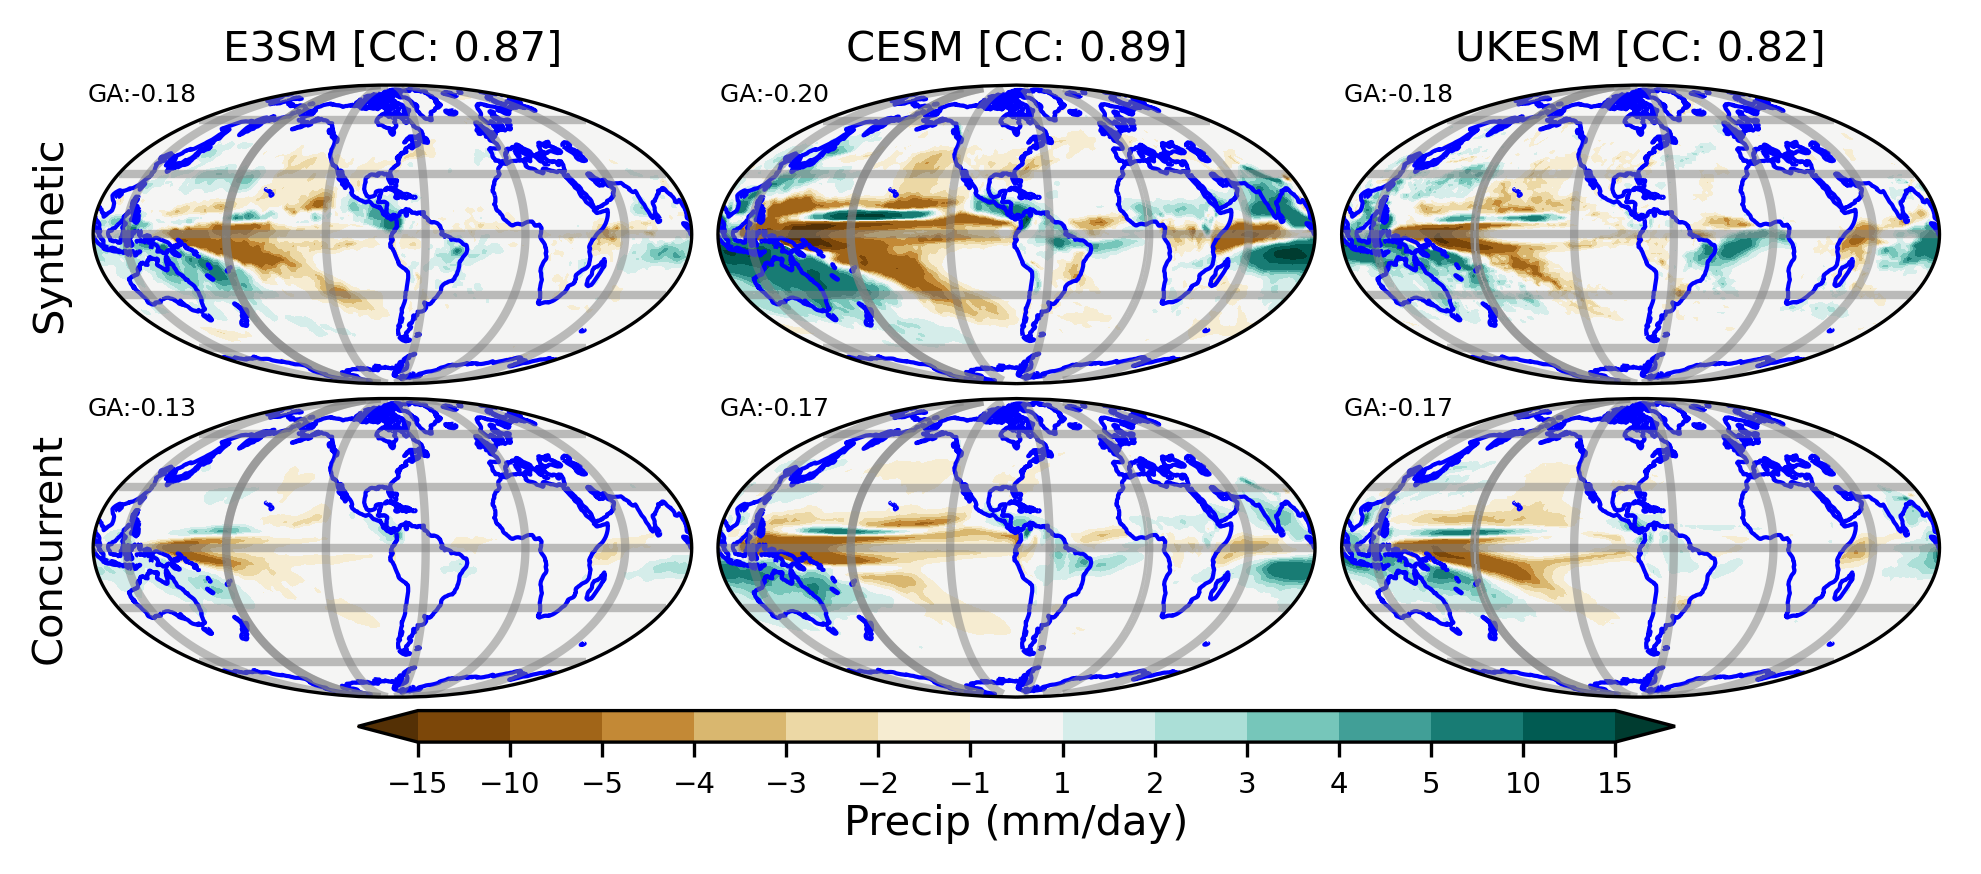

sCCU CC: 0.74
plotting range -23.159515380859375 16.3648681640625
sCCE CC: 0.91
sCCC CC: 0.93


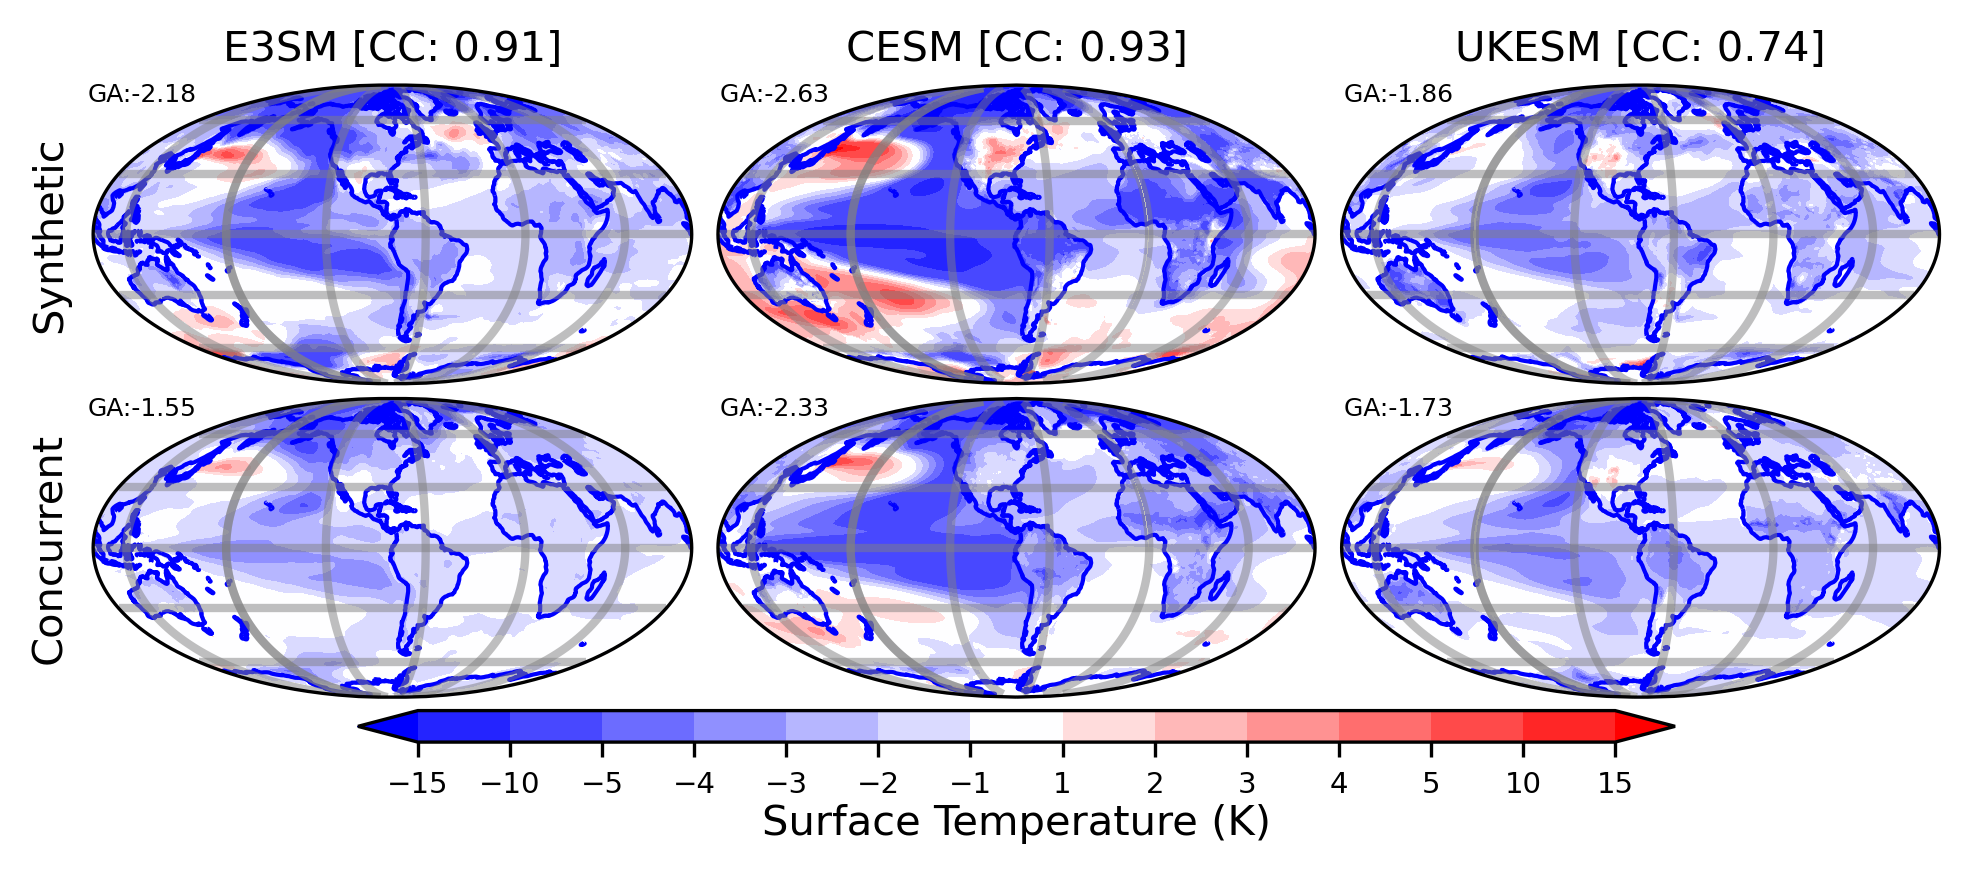

In [18]:
tcmap = diverge_map()
pcmap = plt.get_cmap('BrBG')

plotall (D1245_UKESM_Pr, DS1245_UKESM_Pr, D1245_E3SM_Pr, DS1245_E3SM_Pr, D1245_CESM_Pr, DS1245_CESM_Pr,dmap=pcmap)
#
plotall (D1245_UKESM_TS, DS1245_UKESM_TS, D1245_E3SM_TS, DS1245_E3SM_TS, D1245_CESM_TS, DS1245_CESM_TS,dmap=tcmap)

In [19]:
file.close()